## **Multi-Class Text Classification**

By Twisha Choudhary

**Import libraries**

In [42]:
pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [43]:
import pandas as pd
import numpy as np
import re
import keras
import tensorflow
import pickle
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
#!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner import RandomSearch

**Read the dataset**

In [2]:
df = pd.read_csv('/content/drive/My Drive/data.csv')

In [3]:
df = df[["Text",'Class']]

**Data analysis**

In [4]:
df.head(5)

,Text,Class
0,I have outdated information on my credit repor...,C
1,An account on my credit report has a mistaken ...,C
2,This company refuses to provide me verificatio...,A
3,This complaint is in regards to Square Two Fin...,A
4,Started the refinance of home mortgage process...,B


In [5]:
df.tail(5)

,Text,Class
128951,Barclay closed my Barclay XXXX MasterCard acco...,D
128952,Our son was taken to XXXX XXXX XXXX XXXX XXXX ...,A
128953,I had an account with XXXX in XX/XX/XXXX this ...,A
128954,I was contacted on XX/XX/XXXX email by XXXX fr...,B
128955,I had a debit that was included in my chapter ...,A


In [6]:
df.dtypes

Text     object
Class    object
dtype: object

In [7]:
print(df.columns.values)

['Text' 'Class']


In [8]:
df.shape

(128956, 2)

In [9]:
df

,Text,Class
0,I have outdated information on my credit repor...,C
1,An account on my credit report has a mistaken ...,C
2,This company refuses to provide me verificatio...,A
3,This complaint is in regards to Square Two Fin...,A
4,Started the refinance of home mortgage process...,B
...,...,...
128951,Barclay closed my Barclay XXXX MasterCard acco...,D
128952,Our son was taken to XXXX XXXX XXXX XXXX XXXX ...,A
128953,I had an account with XXXX in XX/XX/XXXX this ...,A
128954,I was contacted on XX/XX/XXXX email by XXXX fr...,B


In [10]:
print(df.isnull().sum())

Text     0
Class    0
dtype: int64


In [11]:
df.groupby('Class').describe()

Text                                                               
       count unique                                                top freq
Class                                                                      
A      43946  42814  This company continues to report on my credit ...   49
B      34576  34550  By failing to adhere to both California law an...    5
C      31589  29828  I am filing this complaint because Experian ha...  103
D      18845  18764  I was shocked when I reviewed my credit report...    6

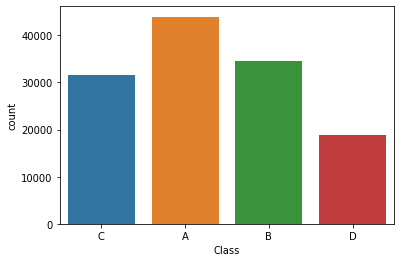

In [12]:
sns.countplot(data=df, x='Class')

**Create lists for the different classes**

Here, we are creating different lists for different classes A, B, C and D of our dataset

In [13]:
A=[]
for i in range(0,128956):
    if df["Class"][i] == "A":
        #(df["Class"][i])C
        A.append(df["Text"][i])

B=[]
for i in range(0,128956):    
    if df["Class"][i] == "B":
        #(df["Class"][i])
        B.append(df["Text"][i])

C=[]
for i in range(0,128956):    
    if df["Class"][i] == "C":
        #(df["Class"][i])
        C.append(df["Text"][i])

D=[]
for i in range(0,128956):    
    if df["Class"][i] == "D":
        #(df["Class"][i])
        D.append(df["Text"][i])

In [14]:
type(A)

list

**Get the training data**

In [15]:
Wtrain_passages = []
train_labels = []

for i in range(8000):
    train_passages.append(A[i])
    train_labels.append('A')

for i in range(8000):
    train_passages.append(B[i])
    train_labels.append('B')

for i in range(8000):
    train_passages.append(C[i])
    train_labels.append('C')

for i in range(8000):
    train_passages.append(D[i])
    train_labels.append('D')

In [16]:
df = pd.DataFrame(list(zip(train_passages, train_labels)), columns =["Text",'Class']) 
df = df.sample(frac = 1) #Shuffle the data

df.to_csv("train.csv")

In [17]:
dfTrain = pd.read_csv('/content/train.csv')

In [18]:
dfTrain

,Unnamed: 0,Text,Class
0,14411,My loan was assumed by OCWEN in 2013. I have b...,B
1,24117,I HAVE BEEN DISPUTING XXXX XXXX BUSINESS XXXX ...,D
2,8203,Ditech financial was servicing my mortgage at ...,B
3,6623,"The phone rings 2 to 3 times a day, using diff...",A
4,165,"First, I want to state the the choices you hav...",A
...,...,...,...
31995,23159,Per Case number XXXX XXXX XXXX states that the...,C
31996,25835,Chevron Gas Texaco continues to use deceptive ...,D
31997,10729,"For Over 30 months, I was enrolled in MHA prog...",B
31998,3256,I have paid XXXX ins. 1 month in advance since...,A


**Labelize the classes**

In [19]:
label = pd.get_dummies(dfTrain["Class"],).values

In [20]:
label

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

In [21]:
type(label)

numpy.ndarray

**Clean the data**

Here, we preprocess the data and clean it.
We correct the contradictions, remove punctuations, and other symbols/texts that are not required.

In [22]:
def clean_text(x):

  x = re.sub(r"n\'t", "not",x)
  x = re.sub(r"\'t","not",x)
  x = re.sub(r"\'ve","have",x)
  x = re.sub(r"\'m","am",x)
  x = re.sub(r"\'d","would",x)
  x = re.sub(r"\'ll","will",x)
  x = re.sub(r"\'re","are",x)
  x = re.sub(r"\'s","is",x)  

  x = re.sub(r'\s\s+',' ',x)
  x = re.sub(r' +', ' ', x)
  
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', x)
  text = text.replace('XXXX', '')
  return text

In [23]:
passages = dfTrain['Text'].values

In [24]:
clean_passage = []
for passage in passages:
  clean_passage.append(clean_text(passage))
#print(len(clean_passage))

In [25]:
clean_passage[:5]

['My loan was assumed by OCWEN in 2013 I have been receiving phone calls stating that I am behind on payments and charged late feesI made payments to OCWEN for my mortgage In looking at my payment history OCWEN applied some these payments directly to the principal balance This created a shortage or  suspense  for the following month I have called to have the principal payments applied as a regular payments to my account OCWEN not processing payments correctly to my account  Suspense  and  payment rev  is are not being credited properly to the account I am being charged late fees and they have reported this on my credit report',
 'I HAVE BEEN DISPUTING   BUSINESS  ACCT ENDING IN  WITH   FRAUD DEPT  ID   PHONE   EX   ON  HE INFORMED ME THAT A BALANCE TRANSFER FROM THIS FRAUD   BUSINESS  ON  410000 WAS PAID TO AN AMERICAN EXPRESS ACCT ENDING IN  IN MY NAME I CONTACTED AMERICAN EXPRESS AND WAS INFORMED THAT AN ACCOUNT WAS NOT OPENED IN MY NAME AS THE CARDHOLDER  BUT AS AN ADDITONAL CARD I 

In [26]:
#Check unique values
clean_set = set() 
for passage in clean_passage:
  for i in passage.split(" "):
    clean_set.add(i)
len(clean_set)

52622

**Tokenize the data**

In [27]:
tokenizer = Tokenizer(num_words=52622)
tokenizer.fit_on_texts(list(clean_passage))
train_X = tokenizer.texts_to_sequences(clean_passage)

Pad sequence

In [28]:
train_X = pad_sequences(train_X, maxlen = 2000)

In [29]:
train_X.shape

(32000, 2000)

In [30]:
label.shape

(32000, 4)

**Train the model**

In [83]:
# model = Sequential()
# model.add(Embedding(52622, 100, input_length = train_X.shape[1]))
# model.add(LSTM(128, return_sequences = True))
# model.add(LSTM(64))
# model.add(Dense(32, activation='tanh'))
# model.add(Dense(4, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = model.fit(train_X, label, epochs = 5, batch_size = 64, validation_split = 0.1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)])


In [49]:
def model(hp):
  
    model = Sequential()
    model.add(Embedding(52622, 100, input_length = train_X.shape[1]))
    model.add(LSTM(units = hp.Int('lstm1_nodes', min_value=32, max_value=256, step=16), return_sequences = True))
    model.add(LSTM(units = hp.Int('lstm1_nodes', min_value=32, max_value=128, step=16)))
    model.add(Dense(units = hp.Int('dense', min_value=16, max_value=64, step=16), activation='tanh'))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [51]:
tuner_search = RandomSearch(model,
                          objective='val_accuracy',
                          max_trials=5, directory='output', project_name="Morningstar")
tuner_search.search(train_X,label, epochs=3, batch_size = 64, validation_split=0.2, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)])

INFO:tensorflow:Reloading Oracle from existing project output/Morningstar/oracle.json
Epoch 1/3
400/400 [==============================] - 325s 812ms/step - loss: 0.8265 - accuracy: 0.6617 - val_loss: 0.8644 - val_accuracy: 0.6905
Epoch 2/3
400/400 [==============================] - 324s 810ms/step - loss: 1.0424 - accuracy: 0.5243 - val_loss: 1.3857 - val_accuracy: 0.2566
Epoch 3/3
400/400 [==============================] - 324s 809ms/step - loss: 1.3033 - accuracy: 0.3424 - val_loss: 0.9542 - val_accuracy: 0.6273


Epoch 1/3
400/400 [==============================] - 210s 525ms/step - loss: 0.7308 - accuracy: 0.7069 - val_loss: 0.4379 - val_accuracy: 0.8664
Epoch 2/3
400/400 [==============================] - 210s 525ms/step - loss: 0.5049 - accuracy: 0.8308 - val_loss: 0.4404 - val_accuracy: 0.8591
Epoch 3/3
400/400 [==============================] - 202s 506ms/step - loss: 0.4358 - accuracy: 0.8676 - val_loss: 0.5139 - val_accuracy: 0.8361


Epoch 1/3
400/400 [==============================] - 263s 658ms/step - loss: 0.9139 - accuracy: 0.6150 - val_loss: 0.7467 - val_accuracy: 0.7106
Epoch 2/3
400/400 [==============================] - 262s 656ms/step - loss: 0.6818 - accuracy: 0.7504 - val_loss: 0.5593 - val_accuracy: 0.8078
Epoch 3/3
400/400 [==============================] - 262s 655ms/step - loss: 0.6589 - accuracy: 0.7437 - val_loss: 0.8760 - val_accuracy: 0.6184


Epoch 1/3
400/400 [==============================] - 207s 518ms/step - loss: 0.7476 - accuracy: 0.7019 - val_loss: 0.5960 - val_accuracy: 0.8191
Epoch 2/3
400/400 [==============================] - 207s 518ms/step - loss: 0.4486 - accuracy: 0.8662 - val_loss: 0.4301 - val_accuracy: 0.8717
Epoch 3/3
400/400 [==============================] - 207s 517ms/step - loss: 0.3893 - accuracy: 0.8784 - val_loss: 0.4734 - val_accuracy: 0.8434


Epoch 1/3
400/400 [==============================] - 389s 973ms/step - loss: 0.8647 - accuracy: 0.6515 - val_loss: 1.5329 - val_accuracy: 0.2461
Epoch 2/3
400/400 [==============================] - 388s 971ms/step - loss: 0.9167 - accuracy: 0.6059 - val_loss: 0.8761 - val_accuracy: 0.6636
Epoch 3/3
400/400 [==============================] - 389s 972ms/step - loss: 0.8438 - accuracy: 0.6523 - val_loss: 0.6623 - val_accuracy: 0.7483


INFO:tensorflow:Oracle triggered exit


In [52]:
model=tuner_search.get_best_models(num_models = 1)[0]

In [55]:
model.fit(train_X, label, epochs = 3, validation_split = 0.1)

Epoch 1/3
900/900 [==============================] - 419s 466ms/step - loss: 0.5464 - accuracy: 0.8165 - val_loss: 0.4828 - val_accuracy: 0.8572
Epoch 2/3
900/900 [==============================] - 417s 464ms/step - loss: 0.5664 - accuracy: 0.8032 - val_loss: 0.4615 - val_accuracy: 0.8553
Epoch 3/3
900/900 [==============================] - 416s 462ms/step - loss: 0.4849 - accuracy: 0.8392 - val_loss: 0.4628 - val_accuracy: 0.8597


**Model details**

In [56]:
e = model.evaluate(train_X, label, batch_size=64)

500/500 [==============================] - 100s 200ms/step - loss: 0.3820 - accuracy: 0.8888


In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 100)         5262200   
_________________________________________________________________
lstm (LSTM)                  (None, 2000, 48)          28608     
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense (Dense)                (None, 96)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 388       
Total params: 5,314,524
Trainable params: 5,314,524
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.save("MorningstarModel.h5")

In [59]:
sample = model.predict(train_X[:5])

In [60]:
sample

array([[0.0562587 , 0.9061795 , 0.02193261, 0.01562918],
       [0.02866109, 0.10714222, 0.03529239, 0.82890433],
       [0.04402265, 0.9258562 , 0.01382744, 0.01629372],
       [0.90356433, 0.00885212, 0.02515249, 0.06243108],
       [0.89477557, 0.01069415, 0.02358393, 0.07094631]], dtype=float32)

In [61]:
label[:5]

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [62]:
for i in sample:
  value = np.argmax(i)+1
  if value == 1:
    print("A")
  elif value == 2:
    print("B")
  elif value == 3:
    print("C")
  else:
    print("D")

B
D
B
A
A


**Get test data**

In [63]:
test_passages = []
test_labels = []

for i in range(8000,10000,1):
    test_passages.append(A[i])
    test_labels.append('A')

for i in range(8000,10000,1):
    test_passages.append(B[i])
    test_labels.append('B')

for i in range(8000,10000,1):
    test_passages.append(C[i])
    test_labels.append('C')

for i in range(8000,10000,1):
    test_passages.append(D[i])
    test_labels.append('D')

In [64]:
df = pd.DataFrame(list(zip(test_passages, test_labels)), columns =["Text",'Class']) 
df = df.sample(frac = 1)

df.to_csv("test.csv")

In [65]:
dfTest = pd.read_csv('/content/test.csv')

In [66]:
dfTest

,Unnamed: 0,Text,Class
0,2007,"As of XXXX XXXX, 2016 XXXX XXXX sold the servi...",B
1,3073,My husband and I are wanting to purchase a mob...,B
2,5297,I sent a letter XX/XX/2015 questioning my cred...,C
3,366,They call 4-5 times a day everyday for a payme...,A
4,1848,I received a credit report from XXXX. In said ...,A
...,...,...,...
7995,238,This balance of {$180.00} was supposed to have...,A
7996,5746,"Equifax has me living at XXXX different XXXX, ...",C
7997,2472,File a mortgage complaintWe made an attempt to...,B
7998,3144,Today I received notification from my credit r...,B


**Clean the data**

In [67]:
passages = dfTest['Text'].values
clean_passage=[]
for passage in passages:
  clean_passage.append(clean_text(passage))
print(len(clean_passage))

8000


In [68]:
clean_passage[:5]

['As of   2016   sold the servicing rights to my mortgage to a company called  at          Co  I have made numerous phone calls requesting monthly mortgage statement and as of today   2016 I have not received statements for   or  payments already paid This is not acceptable I want monthly statements reflecting all required infomation ie balance date payment received allocation to interestprinciple escrow balance etc The last phone call I made to the company a customer service person said they are having trouble with a new  Vendor  I still have no statements Please help',
 'My husband and I are wanting to purchase a mobile home and after trying to fill out the inhouse lender through the mobile home park it prompt me to this page  unfortunately we do not have a lender that match your needs etc  then I picked the Quicken loan  see weblink  Then I had applied through Quicken Loan and wrote both my SSN and my spouse To my surprised it gave me an error and never received a result An agent ph

**Labelize the data**

In [69]:
label = pd.get_dummies(dfTest["Class"],).values
#trainY = to_categorical(label)

**Tokenizer**

In [70]:
test_Y = tokenizer.texts_to_sequences(clean_passage)

**Pad sequence**

In [71]:
test_Y = pad_sequences(test_Y, maxlen = 2000)

In [99]:
model = load_model("/content/MorningstarModel.h5") 

**Metrics**

In [100]:
prediction = model.predict(test_Y)

In [101]:
x = []
for i in label:
  x.append(np.argmax(i)) 

In [102]:
y = []
for i in prediction:
  y.append(np.argmax(i)) 

In [103]:
x[:5]

[1, 1, 2, 0, 0]

In [104]:
y[:5]

[1, 1, 2, 0, 2]

In [105]:
cm = confusion_matrix(x, y)

In [106]:
cm

array([[1735,   81,  119,   65],
       [  87, 1852,   32,   29],
       [ 227,   41, 1671,   61],
       [ 214,  149,  136, 1501]])

In [107]:
print(accuracy_score(x,y))

0.844875


In [108]:
names = ['A', 'B', 'C', 'D']

In [109]:
print(classification_report(x, y, target_names = names))

              precision    recall  f1-score   support

           A       0.77      0.87      0.81      2000
           B       0.87      0.93      0.90      2000
           C       0.85      0.84      0.84      2000
           D       0.91      0.75      0.82      2000

    accuracy                           0.84      8000
   macro avg       0.85      0.84      0.84      8000
weighted avg       0.85      0.84      0.84      8000

